<a href="https://colab.research.google.com/github/amoyag/Biofisica/blob/main/S3_FFL_profesor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Banco de módulos

In [1]:
#@title Módulo 0: Librerías y configuración.

# Módulo 0: Librerías y configuración
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

# Estilo visual consistente con sesión 2
plt.style.use('classic')
sns.set_theme(style="whitegrid")


In [10]:

def model_ffl_and(t, y, params):
    X, Y, Z = y
    u_val = params["input"](t)
    beta_X, alpha_X = params["X"]["beta"], params["X"]["alpha"]
    beta_Y, alpha_Y, K_Y = params["Y"]["beta"], params["Y"]["alpha"], params["Y"]["K"]
    beta_Z, alpha_Z, K_Z, Kp_Z = params["Z"]["beta"], params["Z"]["alpha"], params["Z"]["K"], params["Z"]["Kp"]
    nY = params["Z"].get("nY", 1)  # por defecto 1 (sin cooperatividad)

    dXdt = beta_X * u - alpha_X * X
    dYdt = (beta_Y * X / (K_Y + X)) - alpha_Y * Y
    act_X = X / (K_Z + X)
    act_Y = (Y**nY) / (Kp_Z**nY + Y**nY)
    dZdt = beta_Z * act_X * act_Y - alpha_Z * Z
    return [dXdt, dYdt, dZdt]




def model_cascade(t, y, params):
    X, Z = y
    # Call the input function with time t
    u_val = params["input"](t)
    beta_X, alpha_X = params["X"]["beta"], params["X"]["alpha"]
    beta_Z, alpha_Z, K_Z = params["Z"]["beta"], params["Z"]["alpha"], params["Z"]["K"]

    dXdt = beta_X * u_val - alpha_X * X
    dZdt = (beta_Z * X / (K_Z + X)) - alpha_Z * Z
    return [dXdt, dZdt]


In [14]:
#@title Módulo 2: Configuración (build_config)

def build_config(model="ffl", input_type="step", t_span=(0, 100), y0=None):
    if input_type == "step":
        input_func = lambda t: 1 if t >= 0 else 0
    elif input_type == "pulse":
        input_func = lambda t: 1 if 0 <= t <= 20 else 0

    params = {
        "input": input_func,
        "X": {"beta": 1.0, "alpha": 0.1},
        "Y": {"beta": 1.0, "alpha": 0.5, "K": 1.0},
        "Z": {"beta": 1.0, "alpha": 0.05, "K": 1.0, "Kp": 1.0, "nY": 1}
    }

    if y0 is None:
        y0 = [0, 0, 0] if model == "ffl" else [0, 0]

    return params, t_span, y0


In [4]:
#@title Módulo 3: Ejecución (run_simulation)

def run_simulation(model_func, params, t_span, y0, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 1000)
    sol = solve_ivp(model_func, t_span, y0, args=(params,), t_eval=t_eval)
    return sol.t, sol.y


In [5]:
#@title Módulo 4: Visualización (plot_timeseries, plot_heatmap)

def plot_timeseries(t, y, labels):
    plt.figure(figsize=(8, 5))
    for i, label in enumerate(labels):
        plt.plot(t, y[i], label=label)
    plt.xlabel("Tiempo")
    plt.ylabel("Concentración")
    plt.legend()
    plt.show()

def plot_heatmap(matrix, x_vals, y_vals, xlabel, ylabel):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, origin='lower', aspect='auto', extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
    plt.colorbar(label="Tiempo de activación")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [6]:
#@title Módulo 5: Análisis (compute_activation_time)

def compute_activation_time(t, z, threshold=0.5):
    max_val = np.max(z)
    target = threshold * max_val
    idx = np.where(z >= target)[0]
    return t[idx[0]] if len(idx) > 0 else None


In [7]:
#@title Módulo 6: Barrido de parámetros (parameter_scan)

# Módulo 6: Barrido de parámetros y visualización con Seaborn
def parameter_scan(model_func, base_params, t_span, y0, param_x, param_y, x_range, y_range):
    """
    Realiza un barrido de parámetros para dos variables y calcula el tiempo de activación de Z.

    Args:
        model_func: función del modelo (FFL AND).
        base_params: diccionario con parámetros base.
        t_span: tupla (t0, tf).
        y0: condiciones iniciales.
        param_x: nombre del parámetro en eje X (ej. 'beta').
        param_y: nombre del parámetro en eje Y (ej. 'alpha').
        x_range: lista o array con valores para param_x.
        y_range: lista o array con valores para param_y.

    Returns:
        matriz con tiempos de activación.
    """
    results = np.zeros((len(y_range), len(x_range)))

    for i, y_val in enumerate(y_range):
        for j, x_val in enumerate(x_range):
            params = base_params.copy()
            params["Y"]["beta"] = x_val
            params["Y"]["alpha"] = y_val

            t, sol_y = run_simulation(model_func, params, t_span, y0)
            activation_time = compute_activation_time(t, sol_y[-1])
            results[i, j] = activation_time if activation_time else np.nan

    return results

def plot_heatmap(matrix, x_vals, y_vals, xlabel, ylabel, cmap="viridis"):
    """
    Genera un mapa de calor con Seaborn para visualizar el tiempo de activación.
    """
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(matrix, xticklabels=np.round(x_vals, 2), yticklabels=np.round(y_vals, 2),
                     cmap=cmap, annot=False, cbar_kws={'label': 'Tiempo de activación'})
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title("Mapa de calor: tiempo de activación de Z")
    plt.show()


## Ejercicios

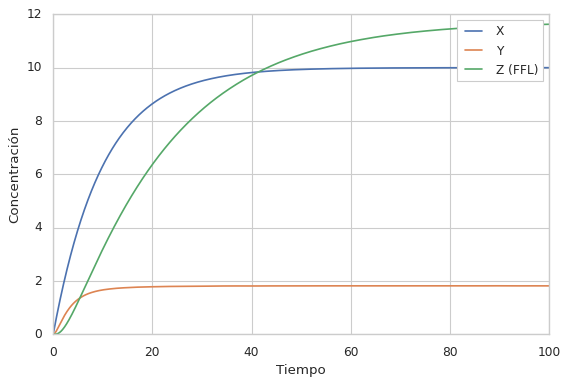

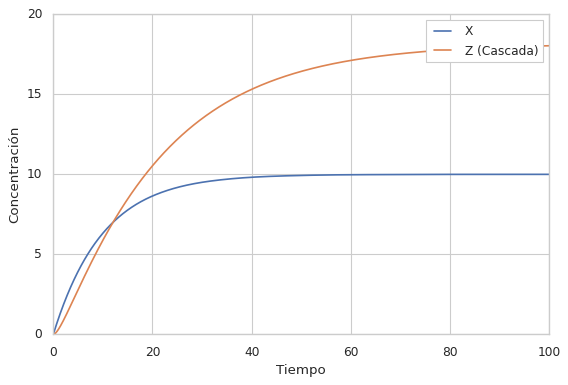

Tiempo activación Z (FFL): 18.02
Tiempo activación Z (Cascada): 16.32


In [33]:

# 1. Configuración
params_ffl, t_span, y0_ffl = build_config(model="ffl", input_type="step", t_span=(0, 100))
params_cascade, _, y0_cascade = build_config(model="cascade", input_type="step", t_span=(0, 100))

# 2. Simulación
t_ffl, y_ffl = run_simulation(model_ffl_and, params_ffl, t_span, y0_ffl)
t_cascade, y_cascade = run_simulation(model_cascade, params_cascade, t_span, y0_cascade)

# 3. Visualización
plot_timeseries(t_ffl, y_ffl, labels=["X", "Y", "Z (FFL)"])
plot_timeseries(t_cascade, y_cascade, labels=["X", "Z (Cascada)"])

# 4. Análisis
t_act_ffl = compute_activation_time(t_ffl, y_ffl[-1])
t_act_cascade = compute_activation_time(t_cascade, y_cascade[-1])
print(f"Tiempo activación Z (FFL): {t_act_ffl:.2f}")
print(f"Tiempo activación Z (Cascada): {t_act_cascade:.2f}")


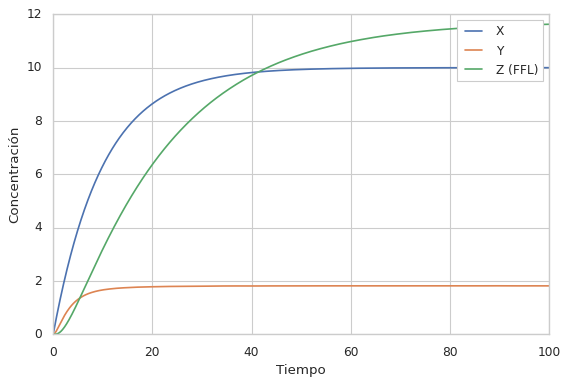

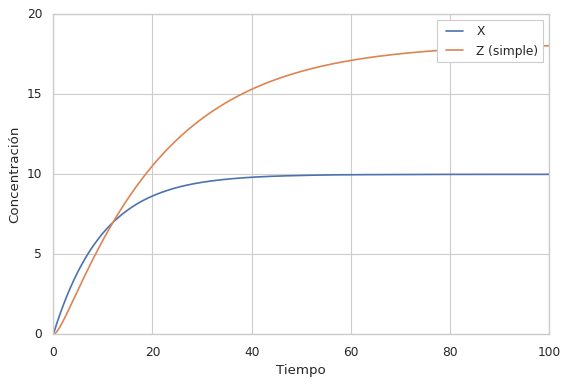

Tiempo activación Z (FFL): 18.02
Tiempo activación Z (simple): 16.32


In [30]:
#@title Ejercicio 1 Delay

# 1. Configuración
params_ffl, t_span, y0_ffl = build_config(model="ffl", input_type="step", t_span=(0, 100))
params_cascade, _, y0_cascade = build_config(model="cascade", input_type="step", t_span=(0, 100))

# 2. Simulación
t_ffl, y_ffl = run_simulation(model_ffl_and, params_ffl, t_span, y0_ffl)
t_cascade, y_cascade = run_simulation(model_cascade, params_cascade, t_span, y0_cascade)

# 3. Visualización
plot_timeseries(t_ffl, y_ffl, labels=["X", "Y", "Z (FFL)"])
plot_timeseries(t_cascade, y_cascade, labels=["X", "Z (simple)"])

# 4. Análisis
t_act_ffl = compute_activation_time(t_ffl, y_ffl[-1])
t_act_cascade = compute_activation_time(t_cascade, y_cascade[-1])
print(f"Tiempo activación Z (FFL): {t_act_ffl:.2f}")
print(f"Tiempo activación Z (simple): {t_act_cascade:.2f}")


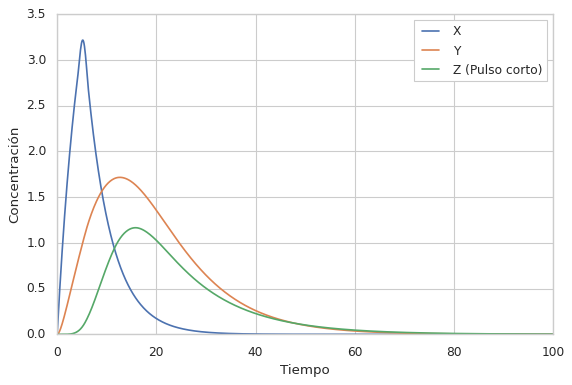

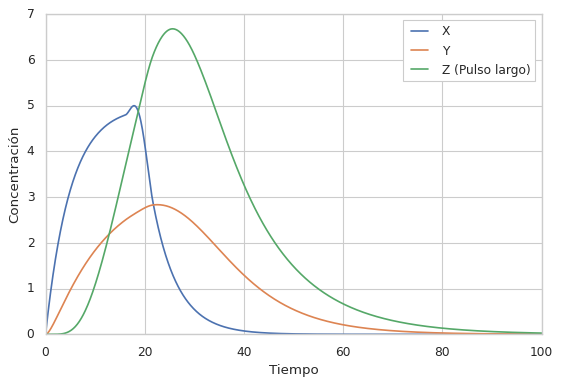

Máximo Z (pulso corto, 0–5):  1.166
Máximo Z (pulso largo, 0–20): 6.683
t_activación Z (pulso largo, 50% máx): 15.415415415415417
t_activación Z (pulso corto, 50% máx): 9.00900900900901


In [41]:
#@title Ejercicio 2 Pulsos



# --- Modelo local con cooperatividad en Y->Z (lógica AND con Hill en Y) ---
def model_ffl_and_hill(t, y, params):
    X, Y, Z = y
    u_val = params["input"](t) # Corrected: call the input function with time t
    beta_X, alpha_X = params["X"]["beta"], params["X"]["alpha"]
    beta_Y, alpha_Y, K_Y = params["Y"]["beta"], params["Y"]["alpha"], params["Y"]["K"]
    beta_Z, alpha_Z, K_Z, Kp_Z = params["Z"]["beta"], params["Z"]["alpha"], params["Z"]["K"], params["Z"]["Kp"]
    nY = params["Z"].get("nY", 3)  # expon. de Hill para Y->Z (por defecto 3)

    # Dinámica
    dXdt = beta_X * u_val - alpha_X * X
    dYdt = (beta_Y * X / (K_Y + X)) - alpha_Y * Y
    act_X = X / (K_Z + X)
    act_Y = (Y**nY) / (Kp_Z**nY + Y**nY)  # Cooperatividad en Y
    dZdt = beta_Z * act_X * act_Y - alpha_Z * Z
    return [dXdt, dYdt, dZdt]

# --- Función auxiliar: entrada pulso con duración configurable ---
def make_pulse(t_on=0.0, duration=5.0, amplitude=1.0):
    return lambda t: amplitude if (t >= t_on) and (t <= t_on + duration) else 0.0

# --- 1) Configuración base moderada ---
params_base, t_span, y0 = build_config(model="ffl", input_type="step", t_span=(0, 100))

# Tiempos característicos: X rápido, Y más lento, Z respuesta notable si Y supera umbral
params_base["X"]["beta"]  = 1.0
params_base["X"]["alpha"] = 0.2

params_base["Y"]["beta"]  = 0.4   # moderado: Y no sube demasiado con pulso corto
params_base["Y"]["alpha"] = 0.10  # más rápida que en el caso original (evita persistencia con pulso corto)
params_base["Y"]["K"]     = 1.0

params_base["Z"]["beta"]  = 2.0   # subida más clara con pulso largo
params_base["Z"]["alpha"] = 0.08
params_base["Z"]["K"]     = 1.5   # X por sí solo no dispara Z
params_base["Z"]["Kp"]    = 2.5   # umbral intermedio; cooperatividad hará el “hard threshold”
params_base["Z"]["nY"]    = 3     # cooperatividad fuerte en Y->Z

# --- 2) Definir dos escenarios de pulso ---
# Pulso corto: 0–5
params_corto = {k: (v.copy() if isinstance(v, dict) else v) for k, v in params_base.items()}
params_corto["input"] = make_pulse(t_on=0.0, duration=5.0, amplitude=1.0)

# Pulso largo: 0–20
params_largo = {k: (v.copy() if isinstance(v, dict) else v) for k, v in params_base.items()}
params_largo["input"] = make_pulse(t_on=0.0, duration=20.0, amplitude=1.0)

# --- 3) Simulación con el modelo cooperativo ---
t_corto, y_corto = run_simulation(model_ffl_and_hill, params_corto, t_span, y0)
t_largo, y_largo = run_simulation(model_ffl_and_hill, params_largo, t_span, y0)

# --- 4) Visualización ---
plot_timeseries(t_corto, y_corto, labels=["X", "Y", "Z (Pulso corto)"])
plot_timeseries(t_largo, y_largo, labels=["X", "Y", "Z (Pulso largo)"])

# --- 5) Análisis cuantitativo ---
Z_corto = y_corto[-1]
Z_largo = y_largo[-1]

max_Z_corto = np.max(Z_corto)
max_Z_largo = np.max(Z_largo)

t_act_largo = compute_activation_time(t_largo, Z_largo, threshold=0.5)  # 50% del máximo largo
t_act_corto = compute_activation_time(t_corto, Z_corto, threshold=0.5)  # debería ser None

print(f"Máximo Z (pulso corto, 0–5):  {max_Z_corto:.3f}")
print(f"Máximo Z (pulso largo, 0–20): {max_Z_largo:.3f}")
print(f"t_activación Z (pulso largo, 50% máx): {t_act_largo if t_act_largo is not None else 'No activa'}")
print(f"t_activación Z (pulso corto, 50% máx): {t_act_corto if t_act_corto is not None else 'No activa'}")


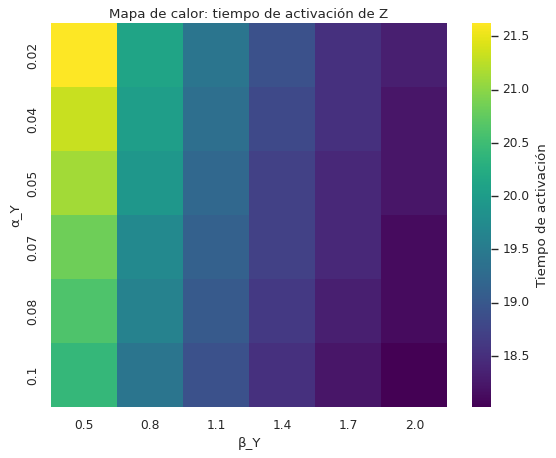

In [39]:
#@title Ejercicio 3 Barrido

# 1. Configuración
params_base, t_span, y0 = build_config(model="ffl", input_type="step", t_span=(0, 100))

# Definimos rangos para β_Y y α_Y
beta_range = np.linspace(0.5, 2.0, 6)   # tasa de síntesis
alpha_range = np.linspace(0.02, 0.1, 6) # tasa de degradación

# 2. Barrido
matrix = parameter_scan(model_ffl_and, params_base, t_span, y0,
                        param_x="beta", param_y="alpha",
                        x_range=beta_range, y_range=alpha_range)

# 3. Visualización
plot_heatmap(matrix, beta_range, alpha_range, xlabel="β_Y", ylabel="α_Y")


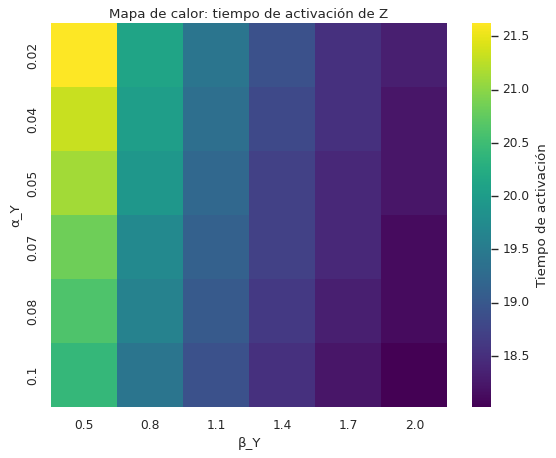

In [20]:
#@title Ejercicio 3 Barrido

# 1. Configuración
params_base, t_span, y0 = build_config(model="ffl", input_type="step", t_span=(0, 100))

# Definimos rangos para β_Y y α_Y
beta_range = np.linspace(0.5, 2.0, 6)   # tasa de síntesis
alpha_range = np.linspace(0.02, 0.1, 6) # tasa de degradación

# 2. Barrido
matrix = parameter_scan(model_ffl_and, params_base, t_span, y0,
                        param_x="beta", param_y="alpha",
                        x_range=beta_range, y_range=alpha_range)

# 3. Visualización
plot_heatmap(matrix, beta_range, alpha_range, xlabel="β_Y", ylabel="α_Y")


In [34]:
#@title Ejercicio 1 interactivo


#@title Ejercicio 1: Comparación FFL vs Cascada Simple (Interactivo)

import ipywidgets as widgets
from IPython.display import display

# Sliders para parámetros clave
beta_X_slider = widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1, description='β_X')
alpha_X_slider = widgets.FloatSlider(value=0.1, min=0.05, max=0.3, step=0.01, description='α_X')
beta_Y_slider = widgets.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.1, description='β_Y')
alpha_Y_slider = widgets.FloatSlider(value=0.05, min=0.02, max=0.2, step=0.01, description='α_Y')

def simulate_delay(beta_X, alpha_X, beta_Y, alpha_Y):
    # Configuración base
    params_ffl, t_span, y0_ffl = build_config(model="ffl", input_type="step", t_span=(0, 100))
    params_cascade, _, y0_cascade = build_config(model="cascade", input_type="step", t_span=(0, 100))

    # Ajustar parámetros según sliders
    params_ffl["X"]["beta"] = beta_X
    params_ffl["X"]["alpha"] = alpha_X
    params_ffl["Y"]["beta"] = beta_Y
    params_ffl["Y"]["alpha"] = alpha_Y

    params_cascade["X"]["beta"] = beta_X
    params_cascade["X"]["alpha"] = alpha_X

    # Simulación
    t_ffl, y_ffl = run_simulation(model_ffl_and, params_ffl, t_span, y0_ffl)
    t_cascade, y_cascade = run_simulation(model_cascade, params_cascade, t_span, y0_cascade)

    # Visualización
    plot_timeseries(t_ffl, y_ffl, labels=["X", "Y", "Z (FFL)"])
    plot_timeseries(t_cascade, y_cascade, labels=["X", "Z (simple)"])

    # Análisis
    t_act_ffl = compute_activation_time(t_ffl, y_ffl[-1])
    t_act_cascade = compute_activation_time(t_cascade, y_cascade[-1])
    print(f"Tiempo activación Z (FFL): {t_act_ffl:.2f}")
    print(f"Tiempo activación Z (simple): {t_act_cascade:.2f}")

# Crear interfaz interactiva
widgets.interactive(simulate_delay, beta_X=beta_X_slider, alpha_X=alpha_X_slider,
                    beta_Y=beta_Y_slider, alpha_Y=alpha_Y_slider)


interactive(children=(FloatSlider(value=1.0, description='β_X', max=3.0, min=0.5), FloatSlider(value=0.1, desc…



### **Ejercicio 2: Respuesta a Pulsos y Filtrado Temporal**

**Objetivo:**  
Explorar cómo el motivo **FFL AND con cooperatividad** actúa como **filtro pasa-largos**, ignorando señales breves y respondiendo solo a pulsos persistentes.

**Instrucciones:**

1.  Usa los **sliders interactivos** para modificar:
    *   **Duración del pulso** (en unidades de tiempo).
    *   **β\_Y** y **α\_Y** (síntesis y degradación de Y).
    *   **Kp\_Z** (umbral para Y en la activación de Z).
    *   **nY** (exponente de Hill para cooperatividad en Y→Z).
2.  Observa:
    *   ¿Qué ocurre con Z cuando el pulso es muy corto?
    *   ¿Qué parámetros hacen que el filtro sea más estricto?
3.  Analiza los valores impresos:
    *   Máximo de Z.
    *   Tiempo de activación (si alcanza el 50% del máximo).
4.  **Pregunta clave:** ¿Cuál es la duración mínima del pulso para que Z se active significativamente?

**Concepto clave:**  
El FFL AND con cooperatividad introduce un **umbral temporal**: solo señales persistentes activan Z, lo que evita respuestas espurias ante ruido.


***

### ✅ ¿Por qué esta versión es segura?

*   **Rangos moderados** en sliders para evitar parámetros extremos que rompan la simulación.
*   Modelo robusto con cooperatividad (`nY`) para mostrar el efecto del umbral temporal.
*   Salida clara: gráfico + métricas (máximo Z y tiempo de activación).

***

¿Quieres que ahora redacte el **enunciado y el código interactivo para el Ejercicio 4 (Barrido de parámetros)** y luego te prepare la **estructura completa del cuaderno del alumno con portada, objetivos y los tres ejercicios interactivos**?


In [42]:
#@title Ejercicio 2: Respuesta a Pulsos (Interactivo)

import ipywidgets as widgets
from IPython.display import display

# Sliders para parámetros clave
dur_slider = widgets.IntSlider(value=5, min=1, max=40, step=1, description='Duración pulso')
beta_Y_slider = widgets.FloatSlider(value=0.4, min=0.1, max=1.0, step=0.05, description='β_Y')
alpha_Y_slider = widgets.FloatSlider(value=0.10, min=0.05, max=0.3, step=0.01, description='α_Y')
Kp_slider = widgets.FloatSlider(value=2.5, min=1.0, max=10.0, step=0.5, description='Kp_Z')
nY_slider = widgets.IntSlider(value=3, min=1, max=4, step=1, description='nY')

# Función auxiliar para generar pulso
def make_pulse(t_on=0.0, duration=5.0, amplitude=1.0):
    return lambda t: amplitude if (t >= t_on) and (t <= t_on + duration) else 0.0

# Modelo con cooperatividad
def model_ffl_and_hill(t, y, params):
    X, Y, Z = y
    u = params["input"](t) # Corrected: Call the input function with time t
    beta_X, alpha_X = params["X"]["beta"], params["X"]["alpha"]
    beta_Y, alpha_Y, K_Y = params["Y"]["beta"], params["Y"]["alpha"], params["Y"]["K"]
    beta_Z, alpha_Z, K_Z, Kp_Z = params["Z"]["beta"], params["Z"]["alpha"], params["Z"]["K"], params["Z"]["Kp"]
    nY = params["Z"].get("nY", 3)
    dXdt = beta_X * u - alpha_X * X
    dYdt = (beta_Y * X / (K_Y + X)) - alpha_Y * Y
    act_X = X / (K_Z + X)
    act_Y = (Y**nY) / (Kp_Z**nY + Y**nY)
    dZdt = beta_Z * act_X * act_Y - alpha_Z * Z
    return [dXdt, dYdt, dZdt]

# Función interactiva
def simulate_pulse(duration, beta_Y, alpha_Y, Kp_Z, nY):
    # Configuración base
    params, t_span, y0 = build_config(model="ffl", input_type="step", t_span=(0, 100))
    params["input"] = make_pulse(t_on=0.0, duration=duration, amplitude=1.0)

    # Ajustes
    params["X"]["beta"] = 1.0
    params["X"]["alpha"] = 0.2
    params["Y"]["beta"] = beta_Y
    params["Y"]["alpha"] = alpha_Y
    params["Y"]["K"] = 1.0
    params["Z"]["beta"] = 2.0
    params["Z"]["alpha"] = 0.08
    params["Z"]["K"] = 1.5
    params["Z"]["Kp"] = Kp_Z
    params["Z"]["nY"] = nY

    # Simulación
    t, y = run_simulation(model_ffl_and_hill, params, t_span, y0)

    # Visualización
    plot_timeseries(t, y, labels=["X", "Y", "Z"])

    # Análisis
    max_Z = np.max(y[-1])
    t_act = compute_activation_time(t, y[-1], threshold=0.5)
    print(f"Duración pulso: {duration}")
    print(f"Máximo Z: {max_Z:.3f}")
    print(f"t_activación Z (50% máx): {t_act if t_act is not None else 'No activa'}")

# Interfaz interactiva
widgets.interactive(simulate_pulse,
                    duration=dur_slider,
                    beta_Y=beta_Y_slider,
                    alpha_Y=alpha_Y_slider,
                    Kp_Z=Kp_slider,
                    nY=nY_slider)


interactive(children=(IntSlider(value=5, description='Duración pulso', max=40, min=1), FloatSlider(value=0.4, …



### **Ejercicio 3: Barrido de Parámetros y Retardo en la Activación**

**Objetivo:**  
Explorar cómo el **retardo en la activación de Z** depende de los parámetros del motivo FFL AND, en particular:

*   **β\_Y** (tasa de síntesis de Y).
*   **α\_Y** (tasa de degradación de Y).

**Instrucciones:**

1.  Usa los **controles interactivos** para definir los rangos de barrido:
    *   Valores mínimos y máximos para **β\_Y** y **α\_Y**.
    *   Número de pasos en cada rango.
2.  Haz clic en el botón para ejecutar el barrido y generar un **mapa de calor**:
    *   El color indica el **tiempo de activación de Z** (tiempo para alcanzar el 50% del máximo).
3.  Analiza:
    *   ¿Qué combinación de parámetros produce el mayor retardo?
    *   ¿Qué combinación hace que Z se active más rápido?
4.  **Pregunta clave:** ¿Por qué el retardo depende tanto de la dinámica de Y?

**Concepto clave:**  
El FFL actúa como filtro temporal porque la acumulación de Y es necesaria para activar Z. Si Y se sintetiza lentamente o se degrada rápido, el retardo aumenta.




FloatSlider(value=0.5, description='β_Y min', max=2.0, min=0.1)

FloatSlider(value=2.0, description='β_Y max', max=5.0, min=0.5)

FloatSlider(value=0.02, description='α_Y min', max=0.2, min=0.01, step=0.01)

FloatSlider(value=0.1, description='α_Y max', max=0.3, min=0.05, step=0.01)

IntSlider(value=6, description='Resolución', max=15, min=3)

Button(button_style='success', description='Ejecutar barrido', style=ButtonStyle())

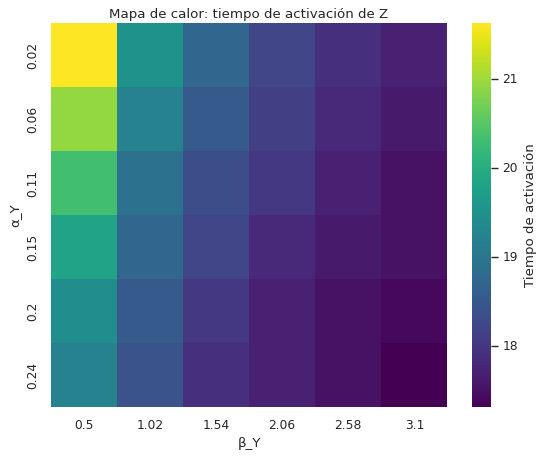

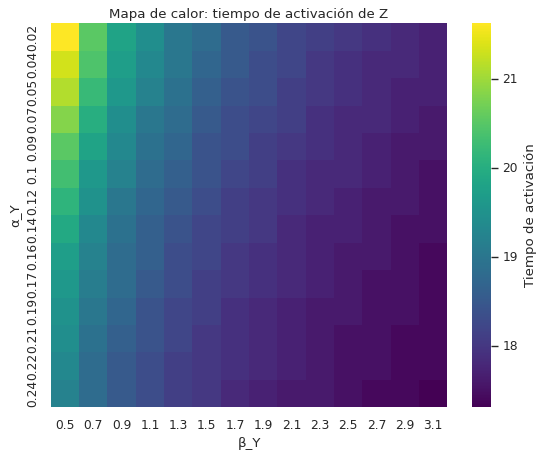

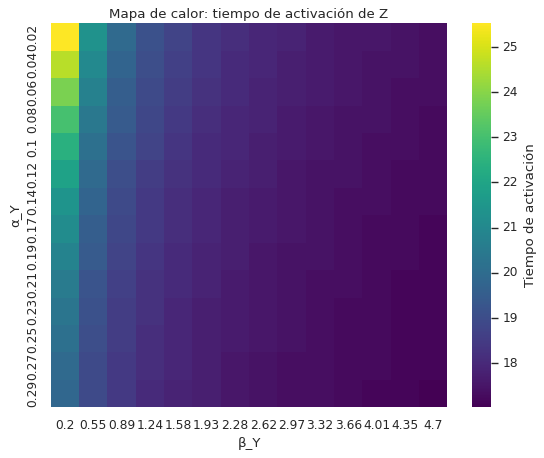

In [ ]:

#@title Ejercicio 4: Barrido de Parámetros (Interactivo)

import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

# Sliders para definir rangos y resolución
beta_min_slider = widgets.FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1, description='β_Y min')
beta_max_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description='β_Y max')
alpha_min_slider = widgets.FloatSlider(value=0.02, min=0.01, max=0.2, step=0.01, description='α_Y min')
alpha_max_slider = widgets.FloatSlider(value=0.1, min=0.05, max=0.3, step=0.01, description='α_Y max')
steps_slider = widgets.IntSlider(value=6, min=3, max=15, step=1, description='Resolución')

# Botón para ejecutar el barrido
run_button = widgets.Button(description="Ejecutar barrido", button_style='success')

# Función para generar heatmap
def run_parameter_scan(b_min, b_max, a_min, a_max, steps):
    # Configuración base
    params_base, t_span, y0 = build_config(model="ffl", input_type="step", t_span=(0, 100))

    # Definir rangos
    beta_range = np.linspace(b_min, b_max, steps)
    alpha_range = np.linspace(a_min, a_max, steps)

    # Matriz de resultados
    results = np.zeros((len(alpha_range), len(beta_range)))

    for i, alpha_val in enumerate(alpha_range):
        for j, beta_val in enumerate(beta_range):
            params = {k: (v.copy() if isinstance(v, dict) else v) for k, v in params_base.items()}
            params["Y"]["beta"] = beta_val
            params["Y"]["alpha"] = alpha_val

            # Simulación
            t, y = run_simulation(model_ffl_and, params, t_span, y0)
            activation_time = compute_activation_time(t, y[-1], threshold=0.5)
            results[i, j] = activation_time if activation_time is not None else np.nan

    # Visualización con Seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(results, xticklabels=np.round(beta_range, 2), yticklabels=np.round(alpha_range, 2),
                     cmap="viridis", annot=False, cbar_kws={'label': 'Tiempo de activación'})
    ax.set_xlabel("β_Y")
    ax.set_ylabel("α_Y")
    plt.title("Mapa de calor: tiempo de activación de Z")
    plt.show()

# Conectar botón con función
def on_button_click(b):
    run_parameter_scan(beta_min_slider.value, beta_max_slider.value,
                       alpha_min_slider.value, alpha_max_slider.value,
                       steps_slider.value)

run_button.on_click(on_button_click)

# Mostrar interfaz
display(beta_min_slider, beta_max_slider, alpha_min_slider, alpha_max_slider, steps_slider, run_button)


Este **mapa de calor** muestra cómo varía el **tiempo de activación de Z** (en el motivo FFL AND) en función de dos parámetros:

*   **Eje X (β\_Y):** tasa de síntesis de Y.
*   **Eje Y (α\_Y):** tasa de degradación de Y.
*   **Color:** tiempo que tarda Z en alcanzar el 50% de su valor máximo (más claro = mayor retardo).

***

### Interpretación del patrón

1.  **Zona superior izquierda (verde/amarillo):**
    *   **β\_Y baja** (≈ 0.2) y **α\_Y baja** (≈ 0.02).
    *   Y se acumula muy lentamente y se degrada despacio → **retardo máximo** (> 25 unidades).
    *   El FFL actúa como un filtro muy estricto: Z tarda mucho en activarse.

2.  **Zona inferior derecha (morado oscuro):**
    *   **β\_Y alta** (> 3.0) y **α\_Y alta** (> 0.25).
    *   Y se acumula rápido pero también se degrada rápido → **retardo mínimo** (\~18 unidades).
    *   El filtro se debilita: Z responde casi tan rápido como una cascada simple.

3.  **Gradiente horizontal:**
    *   Aumentar **β\_Y** reduce el retardo porque Y se acumula más rápido.

4.  **Gradiente vertical:**
    *   Aumentar **α\_Y** también reduce el retardo, pero el efecto es menor que el de β\_Y (porque la degradación afecta más al nivel estacionario que a la velocidad inicial).

***

### conexión con la teoría

*   El FFL introduce un **retardo dependiente de la dinámica de Y**.
*   Si Y es lenta (baja β\_Y, baja α\_Y), el retardo es grande → el circuito filtra pulsos cortos.
*   Si Y es rápida (alta β\_Y, alta α\_Y), el retardo desaparece → el circuito pierde su función de filtro.

***

¿Quieres que redacte **un comentario pedagógico para incluir en el cuaderno del profesor** explicando este resultado y cómo relacionarlo con la lógica evolutiva del FFL?  
¿O prefieres que ahora prepare la **estructura completa del cuaderno del alumno con portada, objetivos y los tres ejercicios interactivos**?


### **Comentario pedagógico para el cuaderno del profesor (Ejercicio 4)**

Este resultado ilustra de manera clara la **dependencia funcional del retardo en la activación de Z respecto a la dinámica de Y** en el motivo FFL AND:

***

#### **Patrón observado**

*   **Zona superior izquierda (verde/amarillo):**
    *   β\_Y baja y α\_Y baja → Y se acumula muy lentamente y se degrada despacio.
    *   Esto provoca que Z tarde mucho en alcanzar el 50% de su máximo (retardo > 25 unidades).
    *   El circuito actúa como un **filtro temporal muy estricto**, ignorando señales transitorias.

*   **Zona inferior derecha (morado oscuro):**
    *   β\_Y alta y α\_Y alta → Y se acumula rápido y también se degrada rápido.
    *   El retardo se reduce (\~18 unidades), el filtro se debilita y Z responde casi tan rápido como una cascada simple.

*   **Gradiente horizontal:**
    *   Aumentar β\_Y reduce el retardo porque Y se acumula más rápido.

*   **Gradiente vertical:**
    *   Aumentar α\_Y también reduce el retardo, pero el efecto es menor que el de β\_Y.

***

#### **Conexión con la teoría (Alon, Cap. 3)**

*   El FFL introduce un **retardo funcional** porque Z depende de dos señales: X y Y.
*   Este retardo es **adaptativo**: evita respuestas espurias ante señales breves o ruido.
*   Si Y es lenta, el filtro es más estricto → útil en entornos donde las señales transitorias son frecuentes.
*   Si Y es rápida, el filtro desaparece → el circuito pierde su función de discriminación temporal.

***

#### **Preguntas para discusión**

1.  ¿Por qué el retardo depende más de β\_Y que de α\_Y?  
    *(Pista: la síntesis determina la velocidad inicial de acumulación, mientras que la degradación afecta más al nivel estacionario).*

2.  ¿Qué implicaciones evolutivas tiene este comportamiento?  
    *(Por ejemplo, en redes génicas bacterianas, un FFL estricto puede evitar activar genes costosos ante señales fugaces).*

3.  ¿Cómo cambiaría el mapa si añadimos cooperatividad (nY > 1)?  
    *(El gradiente se volvería más abrupto, reforzando el umbral funcional).*

***

¿Quieres que ahora prepare la **estructura completa del cuaderno del alumno** con:

*   Portada y objetivos.
*   Introducción teórica.
*   Los tres ejercicios interactivos (con enunciados y widgets).
*   Espacios para interpretación y preguntas?

Esto te daría un notebook listo para usar en clase. ¿Avanzamos con eso?
